In [23]:
import math
from copy import deepcopy
import random
import chess
from ChessWrapper import ChessWrapper
import time
import signal
from treelib import Node, Tree

In [24]:
from stockfish import Stockfish

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
class Node:
    # need to kep track of:
    # Q, N
    # parent node (need to know parent's N for UCT)
    # children
    # outcome?
    # value <- to be done using a function, as value can be updated as MCTS continues
    def __init__(self, move, parent, tag=0):
        self.move = move # move that we played from the parent state to get to this state
        self.parent = parent # parent Node
        self.N = 0 # number of rollouts
        self.Q = 0 # number of wins
        self.children = {} # children nodes
        self.tag = tag # 
    
    # explore = exploration factor in the Upper Confidence bound applied to Trees (UCT)
    def value(self, explore=math.sqrt(2)):
        if self.N == 0:
            if explore == 0: # if for some reason we do not want any exploration
                return 0
            # TODO: double check, does this make sense?
            return float('inf') # in selection phase, we ensure that MCTS at least gives each child node a chance
        return self.Q / self.N + explore * math.sqrt(math.log(self.parent.N) / self.N)
    
    # self.children is a dictionary mapping move -> resulting child
    def add_children(self, children):
        for child in children:
            self.children[child.move] = child
    
    # print out diagnostic information about the current node
    #
    def print(self):
        print("""
        move: {move},
        parent: {parent},
        N: {N},
        Q: {Q}
        """.format(move=str(self.move), parent=str(self.parent), N=self.N, Q=self.Q))
    
    def __str__(self):
        return "move: {move}, parent: {parent}, N: {N}, Q: {Q}".format(move=str(self.move), parent=str(self.parent), N=self.N, Q=self.Q)

In [7]:
class MCTS:
    
    def __init__(self, state, max_depth):
        self.root_node = Node(None, None)
        self.root_state = deepcopy(state)
        self.max_depth = max_depth
        
        self.num_nodes = 0 # use current number of nodes as a tag for the nodes that go into the treelib Tree
        self.Tree = Tree() # to show the tree using treelib
        self.Tree.create_node(str(self.root_node), self.num_nodes, data=self.root_node)

        # statistics
        self.total_rollouts = 0
        self.total_time = 0
        self.total_depth = 0
    
    # start from the root node, and traverse down the tree by best value order
    def select(self):
        curr_node = self.root_node
        curr_state = deepcopy(self.root_state)
        
        # continue until we hit a leaf
        while len(curr_node.children) != 0:
            children = curr_node.children.values()
            
            # find the max value, and then find the node candidates who have max value
            max_val = -1
            for child in children:
                max_val = max(max_val, child.value())
                
            # unsure: maybe it's possible for ties? seems unlikely but might as well account for it
            max_val_children = [] 
            for child in children:
                if child.value() == max_val:
                    max_val_children.append(child)
                    
            curr_node = random.choice(max_val_children)
            
            curr_state.push(curr_node.move) 
            
            # unexplored, has never done a rollout
            if curr_node.N == 0: 
                return curr_node, curr_state
        
        return curr_node, curr_state
        
            
    # once we select, we try to add all of the possible children (using legal moves)
    # if this is possible, we return True
    # otherwise, we return False
    
    def expand(self, leaf_node, leaf_state):
        if leaf_state.is_game_over(): # TODO: is_game_over must be part of the interface
            return None, None
        
        #next_legal_moves = leaf_state.get_legal_moves()
        prob, next_legal_moves = leaf_state.eval_legal_moves() # try using an informed view of the legal moves?

        
        # Node(move, parent). the leaf node is the parent, and the next move gets us to the child
        
        children = [] # add the children to the leaf node
        for next_move in next_legal_moves:
            self.num_nodes += 1
            children.append(Node(next_move, leaf_node, self.num_nodes))
            
        #children = [Node(next_move, leaf_node) for next_move in next_legal_moves]
        
        
        leaf_node.add_children(children)
        
        # try to add children to Treelib representation
        for child in leaf_node.children.values():
            self.Tree.create_node(str(child), child.tag, parent=leaf_node.tag, data=child)
            
        #node = random.choice(children) # pick random child to simulate
        node = random.choices(children, weights=prob)[0] # pick weighted random child to simulate based on how "good" a move is
        leaf_state.push(node.move)
        
        return node, leaf_state
    
    # if eval=True, try to evaluate the "goodness" of moves
    # otherwise, just do simple random sampling
    def rollout_policy(self, state, eval=False):
        if eval == False:
            return random.choice(state.get_legal_moves())
        else:
            prob, moves = state.eval_legal_moves()
            return random.choices(moves, weights=prob)[0]
    
    # if limit_depth=True, then we artificially terminate the rollout and do an evaluation
    def rollout(self, state, limit_depth=False):
        depth = 0
        state_copy = deepcopy(state) # IMPORTANT: deepcopy the state!
        
        # limit_depth = False: run vanilla MCTS until completion. no eval() function required
        if limit_depth == False:
            while not state_copy.is_game_over():
                state_copy.push(self.rollout_policy(state_copy))
                depth += 1
            # update the number of total rollouts performed so we can calculate average rollouts per second
            self.total_rollouts += 1
            # udpate the number of total depth searched so we can calculate average depth per rollout
            self.total_depth += depth
            return state_copy.outcome() #TODO: define state.outcome() in interface
        else:
            while depth < self.max_depth and not state_copy.is_game_over():
                state_copy.push(self.rollout_policy(state_copy))
                depth += 1
            self.total_rollouts += 1
            self.total_depth += depth
            
            static_eval = state_copy.eval() # TODO: allow for eval() as part of API
            
            #print(static_eval)
            #print(state_copy)
            
            # unsure: is this the right idea? or should i have some sort of threshold (ex: 100 centipawns?)
            if static_eval > 0:
                return chess.WHITE
            elif static_eval < 0:
                return chess.BLACK
            else:
                return None

    def backprop(self, node, turn, outcome):
        reward = 0 if outcome == turn else 1
        if outcome is None: # draw
            reward = 0.5
        
        while node is not None:
            node.N += 1
            node.Q += reward
            node = node.parent
            
            # True = white wins, False = black wins, None = draw
            if outcome is None:
                reward = 0.5
            else:
                reward = 1 - reward
    
    # set a time limit on the search
    def search(self, time_limit):
        def handle_timeout(signum, frame):
            raise TimeoutError
        signal.signal(signal.SIGALRM, handle_timeout)
        signal.alarm(time_limit) # when the limit limit is reached, break out
        
        try:
            while True:
                leaf_node, leaf_state = self.select()
                node, state = self.expand(leaf_node, leaf_state)

                if node is None or state is None: # the game is terminated
                    node, state = leaf_node, leaf_state
                #outcome = self.rollout(state) # TODO: fix this!
                outcome = self.rollout(state, limit_depth=True)
                self.backprop(node, state.get_turn(), outcome) #TODO: define to_play in the interface
            
        except TimeoutError:
            self.total_time += time_limit
            print("search completed, total: {t} seconds".format(t=time_limit))
            print("rollouts/sec: {rps}, depth/rollout: {dpr}".format(rps=self.total_rollouts/self.total_time, dpr=self.total_depth/self.total_rollouts))
        finally:
            signal.alarm(0)
        
    def move(self, move):
        if move in self.root_node.children:
            self.root_state.push(move) # move forward in the MCTS
            self.root_node = self.root_node.children[move]
            return
        else:
            self.root_state.push(move)
            self.root_node = Node(None, None)
    
    # choose the action leading to the state w the highest N (most explored node, probably most worthwhile)
    def find_best_move(self):
        if self.root_state.is_game_over():
            raise Exception("Cannot find best move, game has already terminated")
        
        children = self.root_node.children.values()
            
        # find the max value, and then find the node candidates who have max value
        max_N = -1
        for child in children:
            max_N = max(max_N, child.N)
        
        max_N_children = []

        for child in children:
            if child.N == max_N:
                max_N_children.append(child)
                
        return random.choice(max_N_children).move


In [10]:
def play_chess(time_limit, max_depth=10):
    state = ChessWrapper()
    mcts = MCTS(state, max_depth)

    while not state.is_game_over():
        print("Current evaluation:")
        print(state.eval())
        
        print("Current state:")
        state.print()
        

        input_move = input('What is the next move? \n')
        user_move = state.parse_san(input_move)
        
        while user_move not in state.get_legal_moves():
            print("Cannot make illegal move")
            
            input_move = input('What is the next move? \n')
            user_move = state.parse_san(input_move)

        state.push(user_move)
        mcts.move(user_move)

        state.print()

        if state.is_game_over():
            print("Player one wins")
            break

        print("Searching for best move")

        mcts.search(time_limit)
        move = mcts.find_best_move()

        print("MCTS's best move: ", state.san(move))

        state.push(move)
        mcts.move(move)

        if state.is_game_over():
            print("Player two wins")
            break

In [11]:
play_chess(5, max_depth=14)

Current evaluation:
0.0
Current state:
r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


KeyboardInterrupt: Interrupted by user

In [12]:
test = ChessWrapper('rnbqkb1r/pppppppp/8/4P3/8/3P4/PPP2nPP/RNBQKBNR w KQkq - 0 4')

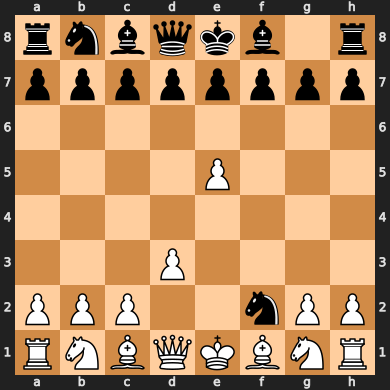

In [13]:
test

In [14]:
test_mcts = MCTS(test, 14)

In [15]:
test_mcts.search(1)

search completed, total: 1 seconds
rollouts/sec: 1198.0, depth/rollout: 13.97161936560935


In [16]:
print(test_mcts.Tree)

In [19]:
test_mcts.Tree.save2file('1.txt')

In [ ]:
# try to reason about what it's seeing in its rollouts
test = ChessWrapper('rnbqkb1r/pppppppp/8/4P3/8/3P4/PPP2nPP/RNBQKBNR w KQkq - 0 4')
print(test)
test_mcts = MCTS(test, 14)
black_win = 0
white_win = 0
for i in range(1000):
    outcome = test_mcts.rollout(test, limit_depth=True)
    if outcome == chess.BLACK:
        black_win += 1
    elif outcome == chess.WHITE:
        white_win += 1
print(black_win)
print(white_win)

In [ ]:
test = ChessWrapper('rnbqkb1r/pppppppp/8/4P3/8/3P4/PPP2KPP/RNBQ1BNR b kq - 0 4')
print(test)
test_mcts = MCTS(test, 14)
black_win = 0
white_win = 0
for i in range(1000):
    outcome = test_mcts.rollout(test, limit_depth=True)
    if outcome == chess.BLACK:
        black_win += 1
    elif outcome == chess.WHITE:
        white_win += 1
print(black_win)
print(white_win)

### Testing M2 Puzzles

In [ ]:
import pickle

In [ ]:
with open('M2_puzzles.pkl', 'rb') as f:
    m2_list = pickle.load(f)

In [ ]:
m2_list

In [ ]:
m2_test = m2_list[0]

In [ ]:
test = ChessWrapper(m2_test)

In [ ]:
from stockfish import Stockfish

In [ ]:
sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')

In [ ]:
sf.set_fen_position(m2_test)

In [ ]:
sf.set_elo_rating(3400)

In [ ]:
mcts = MCTS(test, 14)

In [ ]:
mcts.search(10)

In [ ]:
str(mcts.find_best_move())

In [ ]:
sf.get_best_move()

In [ ]:
m2_test

In [ ]:
correct = 0
total = 0
for fen in m2_list:
    mcts = MCTS(ChessWrapper(fen), 14)
    sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')
    sf.set_elo_rating(3400)
    sf.set_fen_position(fen)
    
    mcts.search(10)
    mcts_best = str(mcts.find_best_move())
    sf_best = sf.get_best_move()
    if mcts_best == sf_best:
        correct += 1
        print(mcts_best)
    total += 1

In [ ]:
def vs_stockfish(elo=300, depth=16, time=3):
    b = ChessWrapper()
    m = MCTS(b, depth)
    sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')
    sf.set_elo_rating(elo)

    while not b.is_game_over():    
        sf_best = sf.get_best_move()

        m.move(chess.Move.from_uci(sf_best))
        sf.make_moves_from_current_position([str(sf_best)])
        b.push(chess.Move.from_uci(sf_best))

        print('stockfish (white) move')
        b.print()

        if b.is_game_over():
            break
        m.search(time)
        mcts_best = m.find_best_move()

        m.move(mcts_best)
        sf.make_moves_from_current_position([str(mcts_best)])
        b.push(mcts_best)

        print('mcts (black) move')
        b.print()
    print(b.outcome())
    return b.outcome()

In [ ]:
wins = 0

for i in range(10):
    outcome = vs_stockfish()
    if outcome.winner == chess.BLACK:
        wins += 1

In [ ]:
b = ChessWrapper()
m = MCTS(b, 16)
sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')
sf.set_elo_rating(500)

while not b.is_game_over():    
    sf_best = sf.get_best_move()
    
    m.move(chess.Move.from_uci(sf_best))
    sf.make_moves_from_current_position([str(sf_best)])
    b.push(chess.Move.from_uci(sf_best))
    
    print('stockfish (white) move')
    b.print()
    
    if b.is_game_over():
        break
    m.search(5)
    mcts_best = m.find_best_move()
    
    m.move(mcts_best)
    sf.make_moves_from_current_position([str(mcts_best)])
    b.push(mcts_best)
    
    print('mcts (black) move')
    b.print()
print(b.outcome())

In [ ]:
b = ChessWrapper()
m = MCTS(b, 16)
sf = Stockfish('/opt/homebrew/Cellar/stockfish/16/bin/stockfish')
sf.set_elo_rating(600)

In [ ]:
sf_best = sf.get_best_move()

m.move(chess.Move.from_uci(sf_best))
sf.make_moves_from_current_position([str(sf_best)])
b.push(chess.Move.from_uci(sf_best))

b.print()

m.search(3)
mcts_best = m.find_best_move()

m.move(mcts_best)
sf.make_moves_from_current_position([str(mcts_best)])
b.push(mcts_best)

b.print()